In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from random import random
import random
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
plt.ion()   # interactive mode

In [2]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [3]:
size= 256
mean = (0.485, 0.456, 0.406)
std = (0.229,0.224, 0.225)
batch_size = 32

In [4]:
trainlists = pd.read_csv('./train_labels.csv')

npdatapath_list=np.array(trainlists)
trainlist, testlist = train_test_split(npdatapath_list, test_size = 0.2)

trainlists.head()

,path,target
0,train_1111.png,0
1,train_5746.png,0
2,train_6365.png,0
3,train_0152.png,1
4,train_0928.png,1


In [5]:
train_path =[]
temp = []
train_label = []
for i,f in enumerate(trainlist):
    temp.append(trainlist[i][0])
    train_label.append(trainlist[i][1])
    train_path.append('./input/train_images/'+temp[i])

test_path =[]
temp2 = []
test_label = []
for i,f in enumerate(testlist):
    temp2.append(testlist[i][0])
    test_label.append(testlist[i][1])
    test_path.append('./input/train_images/'+temp2[i])

In [6]:
def RandomErasing():
    '''
    probability: The probability that the operation will be performed.
    sl: min erasing area
    sh: max erasing area
    r1: min aspect ratio
    mean: erasing value
    -------------------------------------------------------------------------------------
    '''
    probability = 0.5                    #この処理を行う確率
    mean = [0.4914, 0.4822, 0.4465]      # RGBそれぞれの画素値（中間色）
    sl = 0.02                            #マスクする場合の最低の割合
    sh = 0.4                             #マスクする場合の最高の割合
    r1 = 0.3                             #マスクの縦横比

    if random.uniform(0, 1) > probability:  #乱数がprobability(0.5)を超えたら
        return img                          #画像をそのまま返す

        for attempt in range(100):
            area = img.size()[1] * img.size()[2]   #画像サイズを取得
       
            target_area = random.uniform(sl, sh) * area  #面積を決定
            aspect_ratio = random.uniform(r1, 1/r1)      #縦横比を決定

            h = int(round(math.sqrt(target_area * aspect_ratio))) #マスクの高さを決定
            w = int(round(math.sqrt(target_area / aspect_ratio))) #マスクの幅を決定 #img.size() = [3,256,256]
            if w < img.size()[2] and h < img.size()[1]: #画像のサイズをマスクがオーバーしていないことを確認
                x1 = random.randint(0, img.size()[1] - h)     #左上のx座標を決定
                y1 = random.randint(0, img.size()[2] - w)     #左上のy座標を決定
                if img.size()[0] == 3:                  #3チャンネル画像の場合
                    img[0, x1:x1+h, y1:y1+w] = mean[0]  #色で埋める
                    img[1, x1:x1+h, y1:y1+w] = mean[1]
                    img[2, x1:x1+h, y1:y1+w] = mean[2]
                else:                                   #グレースケール画像の場合
                    img[0, x1:x1+h, y1:y1+w] = mean[0]
            
                return img
      
    

In [7]:
def random_erasing(img, p=0.5, sl=0.02, sh=0.4, r1=0.3, r2=3.3):
    target_img = img.copy()

    if p < random.uniform(0, 1):
        return target_img 

    H, W, _ = target_img.shape
    S = H * W

    while True:
        Se = np.random.uniform(sl, sh) * S # 画像に重畳する矩形の面積
        re = np.random.uniform(r1, r2) # 画像に重畳する矩形のアスペクト比

        He = int(np.sqrt(Se * re)) # 画像に重畳する矩形のHeight
        We = int(np.sqrt(Se / re)) # 画像に重畳する矩形のWidth

        xe = np.random.randint(0, W) # 画像に重畳する矩形のx座標
        ye = np.random.randint(0, H) # 画像に重畳する矩形のy座標

        if xe + We <= W and ye + He <= H:
            # 画像に重畳する矩形が画像からはみ出していなければbreak
            break

    mask = np.random.randint(0, 255, (He, We, 3)) # 矩形がを生成 矩形内の値はランダム値
    target_img[ye:ye + He, xe:xe + We, :] = mask # 画像に矩形を重畳

    return target_img

In [8]:
class ImageTransform():
    """
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),  # データオーギュメンテーション
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation((180,180)),# データオーギュメンテーション
                transforms.ToTensor(),# テンソルに変換
                #transforms.Normalize(mean, std),
                #transforms.RandomErasing()# 標準化
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                #transforms.Normalize(mean, std)  # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

In [9]:
class yeardetectDataset(torch.utils.data.Dataset):


    def __init__(self, transform=None, phase='train'):
        #self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        if self.phase == 'train':
            return len(train_path)
        if self.phase == 'val':
            return len(test_path)
        #return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''
        if self.phase == 'train':
            img_path = train_path[index]
            img = Image.open(img_path)
        elif self.phase =='val':
            img_path = test_path[index]
            img = Image.open(img_path)
        # index番目の画像をロード
        #img_path = self.file_list[index]
        #img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(img, self.phase)  # torch.Size([3, 224, 224])

        # 画像のラベル取得
        if self.phase == "train":
            label = train_label[index]
        elif self.phase == "val":
            label = test_label[index]
  
        
        

        return img_transformed, label
    
train_dataset = yeardetectDataset(
    transform=ImageTransform(size, mean, std), phase='train')

val_dataset = yeardetectDataset(
     transform=ImageTransform(size, mean, std), phase='val')

# 動作確認
index = 80
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])


torch.Size([3, 256, 256])
23


In [10]:
# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作確認
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
inputs, labels = next(batch_iterator) 
# 1番目の要素を取り出す
print(inputs.size())
print(labels.size())


torch.Size([32, 3, 256, 256])
torch.Size([32])


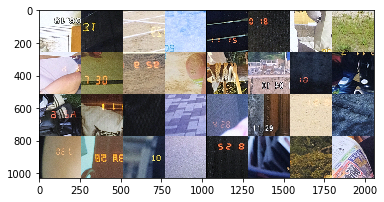

In [11]:
import matplotlib.pyplot as plt
img = torchvision.utils.make_grid(inputs,nrow=8, padding=1)
plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
plt.show()

In [12]:
nfd = 128

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)
    
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, nfd//8 , 3 , 1 , 1 ,bias=False),
            
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nfd//8, nfd//4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfd//4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(nfd//4, nfd//4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(nfd//4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(nfd//4, nfd//2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfd//2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(nfd//2, nfd//2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(nfd//2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(nfd//2, nfd, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfd),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(nfd, nfd, 3, 1, 1, bias=False),
            nn.BatchNorm2d(nfd),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.2),
            
            nn.Conv2d(nfd, nfd*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfd*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(nfd*2, nfd*2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(nfd*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.2),
            
            Flatten(),
            
            nn.Linear(nfd*nfd*nfd//32,40)
        )

    def forward(self, x):
        out = self.main(x)
        return out.squeeze()

In [13]:
from torchsummary import summary
net = Net().to('cuda')
summary(net, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             432
         LeakyReLU-2         [-1, 16, 256, 256]               0
            Conv2d-3         [-1, 32, 128, 128]           8,192
       BatchNorm2d-4         [-1, 32, 128, 128]              64
         LeakyReLU-5         [-1, 32, 128, 128]               0
         Dropout2d-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 32, 128, 128]           9,216
       BatchNorm2d-8         [-1, 32, 128, 128]              64
         LeakyReLU-9         [-1, 32, 128, 128]               0
        Dropout2d-10         [-1, 32, 128, 128]               0
           Conv2d-11           [-1, 64, 64, 64]          32,768
      BatchNorm2d-12           [-1, 64, 64, 64]             128
        LeakyReLU-13           [-1, 64, 64, 64]               0
        Dropout2d-14           [-1, 64,

resnet

import torchvision.models as models
net = models.resnet18(pretrained=True)
# すべてのパラメータを固定
for param in net.parameters():
    param.requires_grad = False

# 最後のfc層を置き換える
# これはデフォルトの requires_grad=True のままなのでパラメータ更新対象
net.fc = nn.Linear(in_features = 512, out_features = 40, bias=True)
net.to('cuda')

In [14]:
#損失関数の決定
criterion = nn.CrossEntropyLoss()
# 最適化手法の設定
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(net.parameters(),lr=0.002, betas=(0.5, 0.999))

In [15]:
def original_criterion(outputs, labels):
    criterion = nn.CrossEntropyLoss()

    loss = 0

    # 正解との誤差
    loss += 0.9 * criterion(outputs, labels)

    # "正解 - 1"との誤差
    loss += 0.05 * criterion(torch.roll(outputs,-1), labels)

    # "正解 + 1"との誤差
    loss += 0.05 * criterion(torch.roll(outputs, 1), labels)
    return loss

In [16]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                inputs = inputs.to('cuda')
                labels = labels.long().to('cuda')
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = original_criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イテレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)

                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.long().data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            
            if phase == 'train':
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc)
                
            if phase =='val':
                if epoch > 1 and epoch_loss < val_loss_list[-1]:
                    save_path = './saved_prm/weights_fujifilm_randomerase_2,6,2'+str(epoch)+'.pth'
                    best_param = copy.deepcopy(net.state_dict())
                    torch.save(best_param,save_path)   
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc)
                

    
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


In [391]:
num_epochs=100
net.train()
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/100
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.75it/s]


val Loss: 3.6898 Acc: 0.0224
Epoch 2/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.16it/s]


train Loss: 21.5509 Acc: 0.0327


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.72it/s]


val Loss: 6.1500 Acc: 0.0209
Epoch 3/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.22it/s]


train Loss: 10.0909 Acc: 0.0447


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.83it/s]


val Loss: 5.5055 Acc: 0.0448
Epoch 4/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 9.2178 Acc: 0.0451


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.91it/s]


val Loss: 7.9997 Acc: 0.0486
Epoch 5/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 8.2365 Acc: 0.0430


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.78it/s]


val Loss: 17.2976 Acc: 0.0448
Epoch 6/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.23it/s]


train Loss: 7.4119 Acc: 0.0421


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.82it/s]


val Loss: 4.8362 Acc: 0.0291
Epoch 7/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 6.7113 Acc: 0.0434


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.82it/s]


val Loss: 3.8402 Acc: 0.0426
Epoch 8/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 5.7487 Acc: 0.0464


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.88it/s]


val Loss: 52.7437 Acc: 0.0015
Epoch 9/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.20it/s]


train Loss: 5.5448 Acc: 0.0482


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.91it/s]


val Loss: 3.7676 Acc: 0.0389
Epoch 10/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 4.4960 Acc: 0.0520


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.70it/s]


val Loss: 4.0754 Acc: 0.0516
Epoch 11/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 4.1378 Acc: 0.0466


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.73it/s]


val Loss: 3.8439 Acc: 0.0688
Epoch 12/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 3.8557 Acc: 0.0507


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.83it/s]


val Loss: 3.9082 Acc: 0.0590
Epoch 13/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.20it/s]


train Loss: 3.6963 Acc: 0.0591


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.84it/s]


val Loss: 3.5264 Acc: 0.0523
Epoch 14/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.20it/s]


train Loss: 3.5876 Acc: 0.0585


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.84it/s]


val Loss: 3.6068 Acc: 0.0643
Epoch 15/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 3.5339 Acc: 0.0636


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.81it/s]


val Loss: 3.4626 Acc: 0.0740
Epoch 16/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.22it/s]


train Loss: 3.5013 Acc: 0.0682


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.76it/s]


val Loss: 3.4693 Acc: 0.0725
Epoch 17/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.4848 Acc: 0.0653


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.86it/s]


val Loss: 3.4767 Acc: 0.0643
Epoch 18/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.4834 Acc: 0.0651


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.84it/s]


val Loss: 3.4645 Acc: 0.0628
Epoch 19/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.22it/s]


train Loss: 3.4780 Acc: 0.0707


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.89it/s]


val Loss: 3.4651 Acc: 0.0665
Epoch 20/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.22it/s]


train Loss: 3.4640 Acc: 0.0686


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.86it/s]


val Loss: 3.4408 Acc: 0.0770
Epoch 21/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 3.4622 Acc: 0.0656


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.81it/s]


val Loss: 3.4605 Acc: 0.0680
Epoch 22/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.4640 Acc: 0.0697


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.84it/s]


val Loss: 3.4528 Acc: 0.0785
Epoch 23/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.20it/s]


train Loss: 3.4541 Acc: 0.0750


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.84it/s]


val Loss: 3.4263 Acc: 0.0665
Epoch 24/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.4545 Acc: 0.0694


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.84it/s]


val Loss: 3.4436 Acc: 0.0710
Epoch 25/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.4506 Acc: 0.0727


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.85it/s]


val Loss: 3.4448 Acc: 0.0635
Epoch 26/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.22it/s]


train Loss: 3.4516 Acc: 0.0711


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.84it/s]


val Loss: 3.4897 Acc: 0.0688
Epoch 27/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.4485 Acc: 0.0752


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.88it/s]


val Loss: 3.4325 Acc: 0.0755
Epoch 28/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.4487 Acc: 0.0739


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.84it/s]


val Loss: 3.4415 Acc: 0.0852
Epoch 29/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.4500 Acc: 0.0688


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.86it/s]


val Loss: 3.4311 Acc: 0.0867
Epoch 30/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.22it/s]


train Loss: 3.4425 Acc: 0.0793


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.83it/s]


val Loss: 3.4563 Acc: 0.0673
Epoch 31/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.4491 Acc: 0.0783


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.75it/s]


val Loss: 3.4312 Acc: 0.0785
Epoch 32/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 3.4401 Acc: 0.0763


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.59it/s]


val Loss: 3.5434 Acc: 0.0628
Epoch 33/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 3.4428 Acc: 0.0726


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.75it/s]


val Loss: 3.4437 Acc: 0.0583
Epoch 34/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 3.4430 Acc: 0.0770


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.70it/s]


val Loss: 3.3945 Acc: 0.0830
Epoch 35/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 3.4355 Acc: 0.0765


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.75it/s]


val Loss: 3.4229 Acc: 0.0859
Epoch 36/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 3.4301 Acc: 0.0849


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.79it/s]


val Loss: 3.4127 Acc: 0.0919
Epoch 37/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.18it/s]


train Loss: 3.4278 Acc: 0.0761


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.84it/s]


val Loss: 3.5502 Acc: 0.0665
Epoch 38/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.22it/s]


train Loss: 3.4195 Acc: 0.0783


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.80it/s]


val Loss: 3.3897 Acc: 0.0919
Epoch 39/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.3986 Acc: 0.0869


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.77it/s]


val Loss: 3.3350 Acc: 0.0919
Epoch 40/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 3.3670 Acc: 0.0907


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.93it/s]


val Loss: 3.3869 Acc: 0.0874
Epoch 41/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 3.3646 Acc: 0.0892


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  8.00it/s]


val Loss: 3.3731 Acc: 0.1009
Epoch 42/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.18it/s]


train Loss: 3.3462 Acc: 0.0937


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.86it/s]


val Loss: 3.8924 Acc: 0.0770
Epoch 43/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.23it/s]


train Loss: 3.3462 Acc: 0.0926


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.90it/s]


val Loss: 3.3423 Acc: 0.0837
Epoch 44/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.3325 Acc: 0.0976


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.83it/s]


val Loss: 4.5004 Acc: 0.0830
Epoch 45/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.20it/s]


train Loss: 3.3132 Acc: 0.0984


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.91it/s]


val Loss: 3.2920 Acc: 0.1129
Epoch 46/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.22it/s]


train Loss: 3.3150 Acc: 0.0978


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.93it/s]


val Loss: 3.2526 Acc: 0.0897
Epoch 47/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.22it/s]


train Loss: 3.3006 Acc: 0.1088


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.84it/s]


val Loss: 3.2699 Acc: 0.1046
Epoch 48/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.3017 Acc: 0.0997


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.97it/s]


val Loss: 3.2668 Acc: 0.0994
Epoch 49/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.22it/s]


train Loss: 3.2995 Acc: 0.1051


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.89it/s]


val Loss: 3.2916 Acc: 0.0845
Epoch 50/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.2958 Acc: 0.0974


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.75it/s]


val Loss: 3.2224 Acc: 0.1136
Epoch 51/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.23it/s]


train Loss: 3.2916 Acc: 0.1028


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.92it/s]


val Loss: 3.6989 Acc: 0.0777
Epoch 52/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.22it/s]


train Loss: 3.2841 Acc: 0.1045


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.88it/s]


val Loss: 3.2533 Acc: 0.1121
Epoch 53/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.17it/s]


train Loss: 3.2850 Acc: 0.1053


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.88it/s]


val Loss: 3.2616 Acc: 0.1166
Epoch 54/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.20it/s]


train Loss: 3.2706 Acc: 0.1118


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.88it/s]


val Loss: 3.4218 Acc: 0.1286
Epoch 55/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.20it/s]


train Loss: 3.2776 Acc: 0.1032


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.87it/s]


val Loss: 3.2399 Acc: 0.0979
Epoch 56/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.20it/s]


train Loss: 3.2718 Acc: 0.1096


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.98it/s]


val Loss: 3.1871 Acc: 0.1203
Epoch 57/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.20it/s]


train Loss: 3.2521 Acc: 0.1214


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.88it/s]


val Loss: 3.2554 Acc: 0.1188
Epoch 58/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.20it/s]


train Loss: 3.2645 Acc: 0.1118


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.91it/s]


val Loss: 3.3484 Acc: 0.0747
Epoch 59/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.20it/s]


train Loss: 3.2642 Acc: 0.1094


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.88it/s]


val Loss: 3.2484 Acc: 0.1233
Epoch 60/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.20it/s]


train Loss: 3.2446 Acc: 0.1126


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.91it/s]


val Loss: 3.2306 Acc: 0.0994
Epoch 61/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.17it/s]


train Loss: 3.2484 Acc: 0.1195


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.91it/s]


val Loss: 3.3960 Acc: 0.1315
Epoch 62/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.20it/s]


train Loss: 3.2414 Acc: 0.1165


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.88it/s]


val Loss: 3.3205 Acc: 0.1241
Epoch 63/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 3.2383 Acc: 0.1193


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.88it/s]


val Loss: 3.2890 Acc: 0.1136
Epoch 64/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.16it/s]


train Loss: 3.2464 Acc: 0.1126


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.72it/s]


val Loss: 3.2279 Acc: 0.1158
Epoch 65/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.22it/s]


train Loss: 3.2395 Acc: 0.1141


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.91it/s]


val Loss: 3.2514 Acc: 0.1151
Epoch 66/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.20it/s]


train Loss: 3.2344 Acc: 0.1230


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.86it/s]


val Loss: 3.2475 Acc: 0.1121
Epoch 67/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.22it/s]


train Loss: 3.2287 Acc: 0.1176


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  8.00it/s]


val Loss: 3.4412 Acc: 0.1196
Epoch 68/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.23it/s]


train Loss: 3.2147 Acc: 0.1238


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.84it/s]


val Loss: 3.1830 Acc: 0.1308
Epoch 69/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 3.2303 Acc: 0.1225


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.98it/s]


val Loss: 3.5949 Acc: 0.1106
Epoch 70/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.2171 Acc: 0.1223


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.86it/s]


val Loss: 3.1054 Acc: 0.1525
Epoch 71/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.20it/s]


train Loss: 3.2259 Acc: 0.1232


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.88it/s]


val Loss: 3.2866 Acc: 0.1263
Epoch 72/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.2101 Acc: 0.1243


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.95it/s]


val Loss: 3.7123 Acc: 0.0523
Epoch 73/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.2042 Acc: 0.1264


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.91it/s]


val Loss: 3.3857 Acc: 0.0919
Epoch 74/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.20it/s]


train Loss: 3.1945 Acc: 0.1260


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.84it/s]


val Loss: 3.1959 Acc: 0.1368
Epoch 75/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.20it/s]


train Loss: 3.1911 Acc: 0.1273


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.98it/s]


val Loss: 3.0798 Acc: 0.1420
Epoch 76/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.1950 Acc: 0.1281


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.93it/s]


val Loss: 3.1312 Acc: 0.1555
Epoch 77/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.1901 Acc: 0.1275


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.95it/s]


val Loss: 3.6315 Acc: 0.1069
Epoch 78/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.23it/s]


train Loss: 3.1945 Acc: 0.1262


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.95it/s]


val Loss: 3.3362 Acc: 0.1495
Epoch 79/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 3.1653 Acc: 0.1365


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.93it/s]


val Loss: 3.1454 Acc: 0.1383
Epoch 80/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.1708 Acc: 0.1288


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  8.02it/s]


val Loss: 3.1100 Acc: 0.1375
Epoch 81/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.20it/s]


train Loss: 3.1733 Acc: 0.1270


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.92it/s]


val Loss: 3.9062 Acc: 0.0807
Epoch 82/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.1665 Acc: 0.1344


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.83it/s]


val Loss: 3.1369 Acc: 0.1420
Epoch 83/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.20it/s]


train Loss: 3.1740 Acc: 0.1268


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.88it/s]


val Loss: 3.0923 Acc: 0.1584
Epoch 84/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.1574 Acc: 0.1384


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.93it/s]


val Loss: 3.1583 Acc: 0.1383
Epoch 85/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.20it/s]


train Loss: 3.1498 Acc: 0.1358


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.98it/s]


val Loss: 2.9790 Acc: 0.1682
Epoch 86/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.20it/s]


train Loss: 3.1447 Acc: 0.1365


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.88it/s]


val Loss: 3.1377 Acc: 0.1517
Epoch 87/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.1471 Acc: 0.1423


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.88it/s]


val Loss: 3.0879 Acc: 0.1450
Epoch 88/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 3.1384 Acc: 0.1438


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  8.02it/s]


val Loss: 3.1907 Acc: 0.0987
Epoch 89/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.1426 Acc: 0.1402


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.98it/s]


val Loss: 3.0551 Acc: 0.1614
Epoch 90/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.22it/s]


train Loss: 3.1470 Acc: 0.1352


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.93it/s]


val Loss: 3.1114 Acc: 0.1592
Epoch 91/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.1236 Acc: 0.1350


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.86it/s]


val Loss: 2.9438 Acc: 0.1592
Epoch 92/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.22it/s]


train Loss: 3.1328 Acc: 0.1395


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.86it/s]


val Loss: 3.1102 Acc: 0.1532
Epoch 93/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.22it/s]


train Loss: 3.1171 Acc: 0.1458


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.93it/s]


val Loss: 2.9068 Acc: 0.1891
Epoch 94/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.20it/s]


train Loss: 3.1038 Acc: 0.1460


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.90it/s]


val Loss: 2.9605 Acc: 0.1644
Epoch 95/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.0997 Acc: 0.1438


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.86it/s]


val Loss: 3.0156 Acc: 0.1764
Epoch 96/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.22it/s]


train Loss: 3.1011 Acc: 0.1445


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.88it/s]


val Loss: 2.9832 Acc: 0.1622
Epoch 97/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.0925 Acc: 0.1505


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.93it/s]


val Loss: 2.9614 Acc: 0.1487
Epoch 98/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:40<00:00,  4.20it/s]


train Loss: 3.0977 Acc: 0.1501


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.90it/s]


val Loss: 3.1434 Acc: 0.1547
Epoch 99/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.0899 Acc: 0.1462


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.93it/s]


val Loss: 3.0882 Acc: 0.1629
Epoch 100/100
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 3.0658 Acc: 0.1530


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.84it/s]


val Loss: 3.1839 Acc: 0.1562


<function matplotlib.pyplot.legend(*args, **kwargs)>

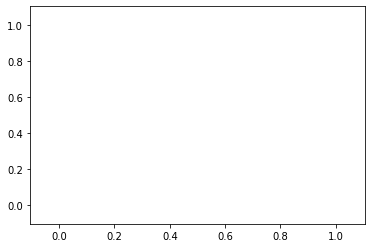

In [25]:
plt.plot(val_loss_list)
plt.plot(train_loss_list)
plt.legend

<function matplotlib.pyplot.legend(*args, **kwargs)>

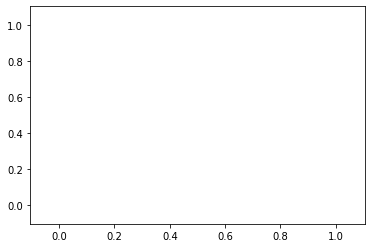

In [26]:
plt.plot(val_acc_list)
plt.plot(train_acc_list)
plt.legend

In [27]:
save_path = './test100_randomerase.pth'
torch.save(net.state_dict(),save_path)

In [28]:
Enet = Net()
Nnet = Net()

In [29]:
#randomerase有の重みの読み込み
load_path = './testprm/not2.pth'
load_weights = torch.load(load_path)
Enet.load_state_dict(load_weights)

<All keys matched successfully>

In [30]:
load_path = './testprm/weights_fujifilm_randomerase_2,6,2599.pth'
load_weights = torch.load(load_path)
Nnet.load_state_dict(load_weights)


<All keys matched successfully>

#GradCAM

image size:  (256, 256)


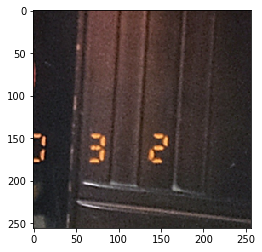

In [83]:
#テスト用画像のロード
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

test_image = Image.open("./input/test_images/test_0123.png")
test_image_tensor = (transform((test_image))).unsqueeze(dim=0)

image_size = test_image.size
print("image size: ", image_size)

plt.imshow(test_image)
image_orig_size = test_image.size

In [84]:
Efeature_fn =nn.Sequential(*list(Enet.children())[-1])[-3].cpu()
print(Efeature_fn)

Dropout2d(p=0.2, inplace=False)


In [85]:
Nfeature_fn =nn.Sequential(*list(Nnet.children())[-1])[-3].cpu()
print(Nfeature_fn)

Dropout2d(p=0.2, inplace=False)


In [86]:
class Gradcam:
    def __init__(self, model, feature_layer):
        self.model = model
        self.feature_layer = feature_layer
        self.model.eval()
        self.feature_grad = None
        self.feature_map = None
        self.hooks = []

        # 最終層逆伝播時の勾配を記録する
        def save_feature_grad(module, in_grad, out_grad):
            self.feature_grad = out_grad[0]
        self.hooks.append(self.feature_layer.register_backward_hook(save_feature_grad))

        # 最終層の出力 Feature Map を記録する
        def save_feature_map(module, inp, outp):
            self.feature_map = outp[0]
        self.hooks.append(self.feature_layer.register_forward_hook(save_feature_map))

    def forward(self, x):
        return self.model(x)

    def backward_on_target(self, output, target):
        self.model.zero_grad()
        one_hot_output = torch.zeros([1, output.size()[-1]])
        one_hot_output[0][target] = 1
        output.backward(gradient=one_hot_output, retain_graph=True)

    def clear_hook(self):
        for hook in self.hooks:
            hook.remove()

In [87]:
#Gradcamクラスのインスタンス化
Egrad_cam = Gradcam(model = Enet.to('cpu'), feature_layer = Efeature_fn)
Ngrad_cam = Gradcam(model = Nnet.to('cpu'), feature_layer = Nfeature_fn)

In [88]:
#テスト画像を入力してアウトプット（予測クラス）を得る
Emodel_output = Egrad_cam.forward(test_image_tensor)
Etarget = Emodel_output.argmax(0).item()

Nmodel_output = Ngrad_cam.forward(test_image_tensor)
Ntarget = Nmodel_output.argmax(0).item()

In [89]:
#アウトプットとターゲットから逆伝播の計算を行う
#アウトプットを出すにあたって寄与したものを見ている？
Egrad_cam.backward_on_target(Emodel_output, Etarget)

Ngrad_cam.backward_on_target(Nmodel_output, Ntarget)

In [90]:
import numpy as np
# Get feature gradient(hookしていたものを取得)
Efeature_grad = Egrad_cam.feature_grad.data.numpy()[0]
Nfeature_grad = Ngrad_cam.feature_grad.data.numpy()[0]
# Get weights from gradient(hookしていたものを取得)
Eweights = np.mean(Efeature_grad, axis=(1, 2))  # Take averages for each gradient
Nweights = np.mean(Nfeature_grad, axis=(1, 2))  # Take averages for each gradient
# Get features outputs(mapを得る)
Efeature_map = Egrad_cam.feature_map.data.numpy()
Nfeature_map = Ngrad_cam.feature_map.data.numpy()

Egrad_cam.clear_hook()
Ngrad_cam.clear_hook()

In [91]:
# CAM画像の作成
Ecam = np.sum((Eweights * Efeature_map.T), axis=2).T
Ecam = np.maximum(Ecam, 0)  # apply ReLU to cam

Ncam = np.sum((Nweights * Nfeature_map.T), axis=2).T
Ncam = np.maximum(Ncam, 0)

In [92]:
VISUALIZE_SIZE = (224, 224)
import cv2
Ecam = cv2.resize(Ecam, VISUALIZE_SIZE)
Ecam = (Ecam - np.min(Ecam)) / (np.max(Ecam) - np.min(Ecam))  # 0-1で正規化
Ecam = np.uint8(Ecam * 255)  # Scale between 0-255 to visualize

Ncam = cv2.resize(Ncam, VISUALIZE_SIZE)
Ncam = (Ncam - np.min(Ncam)) / (np.max(Ncam) - np.min(Ncam))  # 0-1で正規化
Ncam = np.uint8(Ncam * 255)


In [93]:
activation_heatmap = np.expand_dims(Ecam, axis=0).transpose(1,2,0)
org_img = np.asarray(test_image.resize(VISUALIZE_SIZE))
img_with_heatmap = np.multiply(np.float32(activation_heatmap), np.float32(org_img))
img_with_heatmap = img_with_heatmap / np.max(img_with_heatmap)
org_img = cv2.resize(org_img, image_orig_size)

In [94]:
Nactivation_heatmap = np.expand_dims(Ncam, axis=0).transpose(1,2,0)
Norg_img = np.asarray(test_image.resize(VISUALIZE_SIZE))
Nimg_with_heatmap = np.multiply(np.float32(Nactivation_heatmap), np.float32(Norg_img))
Nimg_with_heatmap = Nimg_with_heatmap / np.max(Nimg_with_heatmap)
Norg_img = cv2.resize(Norg_img, image_orig_size)

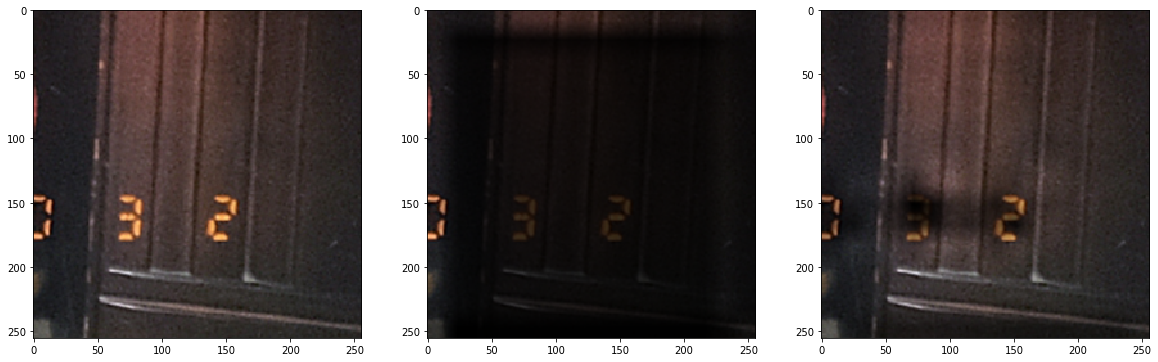

In [95]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(org_img)
plt.subplot(1,3,2)
plt.imshow(cv2.resize(np.uint8(255 * img_with_heatmap), image_orig_size))
plt.subplot(1,3,3)
plt.imshow(cv2.resize(np.uint8(255 * Nimg_with_heatmap), image_orig_size))
plt.show()